In [1]:
# pip install pyspark tensorflow

In [2]:
# pip install scikit-learn

In [3]:
# pip install scikit-learn


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as sklearn_min_max_scaler
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,  StringIndexer
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").appName("ReadSnappyParquet").getOrCreate()

#
parquet_path = "/home/hoan123/project-master/weather_data_transformed2024.csv"
df = spark.read.csv(parquet_path,header=True, inferSchema=True)

df.show()

# Print schema



your 131072x1 screen size is bogus. expect trouble
24/12/09 11:45:31 WARN Utils: Your hostname, LAPTOP-DN3PCHGN resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/09 11:45:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/09 11:45:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      0.0|       Partly cloudy|
|2024-10-18 08:00:00|Hanoi|Vietnam| 21.0333|   105.85|  27.5|     4.3|    77.0|      0.2|   Light rain shower|
|2024-10-18 09:00:00|Hanoi|Vietnam| 21.0333|   105.85|  29.2|     4.9|    69.0|     0.06|Patchy rain possible|
|2024-10-18 10:00:00|Hanoi|Vietnam| 21.0333|   105.85|  30.7|     5.1|    62.0|     0.29|   Light rain shower|
|

In [9]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

# Lấy danh sách các giá trị duy nhất từ cột "condition"
unique_conditions = df.select("condition").distinct().rdd.flatMap(lambda x: x).collect()

# Tạo dictionary để ánh xạ
condition_mapping = {condition: index for index, condition in enumerate(unique_conditions)}

# Tạo UDF để ánh xạ giá trị
map_condition_udf = udf(lambda condition: condition_mapping.get(condition, -1), IntegerType())

# Áp dụng UDF để tạo cột mới
df = df.withColumn("condition_index", map_condition_udf(col("condition")))


In [10]:
df.show()


+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|              6|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|              6|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      0.0|       Partly cloudy|              6|
|2024-10-18 08:00:00|Hanoi|Vietnam| 21.0333|   105.85|  27.5|     4.3|    77.0|      0.2|   Light rain shower|             17|
|2024-10-18 09:00:00|Hanoi|Vietnam| 21.0333|   105.85|  29.2|     4.9|    69.0|     0.06|Patchy rain possible| 

In [11]:
feature_columns = ["wind_mph","humidity","precip_mm","condition_index"]
# Assuming 'temperature_2m' is the target variable
target_variable = 'temp_c'

In [12]:
# Tạo VectorAssembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = vector_assembler.transform(df).select("datetime", "features", col(target_variable).alias("label"))

split_date = "2024-9-20"  # Thay bằng ngày hoặc thời gian phù hợp với dữ liệu của bạn

# Tách dữ liệu thành tập train và test dựa trên khoảng thời gian
train_data = assembled_data.filter(col("datetime") < split_date)
test_data = assembled_data.filter(col("datetime") >= split_date)

# Huấn luyện mô hình RandomForest
rf = RandomForestRegressor(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)


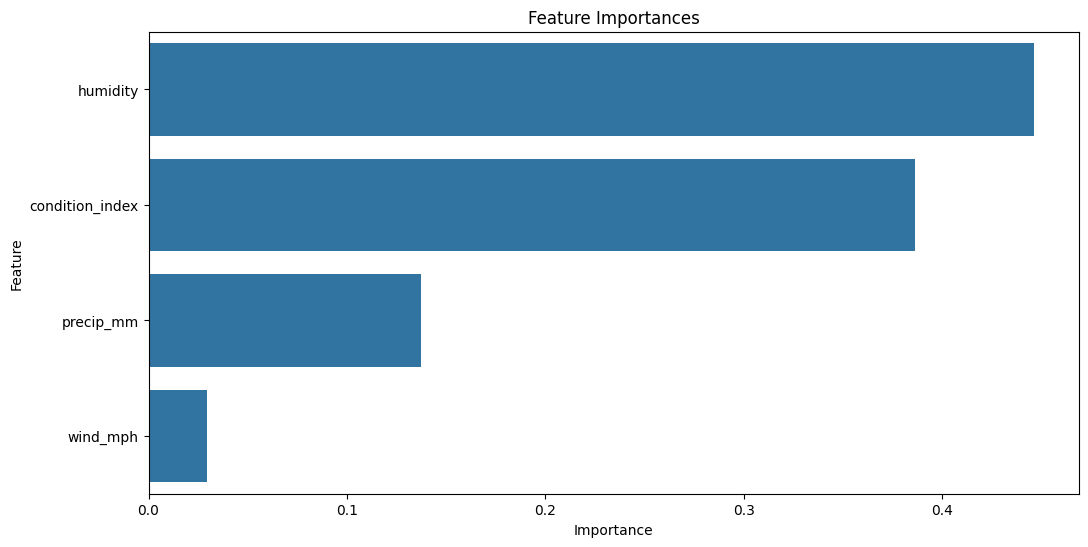

In [13]:
# Lấy độ quan trọng của đặc trưng
feature_importances = rf_model.featureImportances.toArray()

# Tạo DataFrame Pandas để hiển thị
feature_importance_df = pd.DataFrame({"Feature": feature_columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Hiển thị biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importances")
plt.show()

In [14]:
# Chọn 4 đặc trưng quan trọng nhất
selected_features = feature_importance_df["Feature"].head(4).tolist()
print("Selected Features:", selected_features)

# Tạo DataFrame mới với đặc trưng được chọn
final_data = assembled_data.select("datetime", col("label").alias("temperature"), *["features"])
final_data.show(5)

Selected Features: ['humidity', 'condition_index', 'precip_mm', 'wind_mph']
+-------------------+-----------+-------------------+
|           datetime|temperature|           features|
+-------------------+-----------+-------------------+
|2024-10-18 05:00:00|       25.0| [3.1,89.0,0.0,6.0]|
|2024-10-18 06:00:00|       24.9| [3.4,90.0,0.0,6.0]|
|2024-10-18 07:00:00|       25.9| [3.4,85.0,0.0,6.0]|
|2024-10-18 08:00:00|       27.5|[4.3,77.0,0.2,17.0]|
|2024-10-18 09:00:00|       29.2|[4.9,69.0,0.06,2.0]|
+-------------------+-----------+-------------------+
only showing top 5 rows



In [15]:
# Sắp xếp dữ liệu theo thời gian
data = final_data.orderBy("datetime")
data.show(5)


+-------------------+-----------+-------------------+
|           datetime|temperature|           features|
+-------------------+-----------+-------------------+
|2024-01-01 00:00:00|       20.7| [5.8,82.0,0.0,6.0]|
|2024-01-01 01:00:00|       20.4| [6.0,84.0,0.0,0.0]|
|2024-01-01 02:00:00|       20.0| [4.9,85.0,0.0,0.0]|
|2024-01-01 03:00:00|       19.8|[4.5,86.0,0.0,15.0]|
|2024-01-01 04:00:00|       19.6|[4.7,87.0,0.0,15.0]|
+-------------------+-----------+-------------------+
only showing top 5 rows



In [16]:
# Chia dữ liệu dựa trên thời gian
training_data = data.filter(col("datetime") < "2024-10-30 12:00:00")
testing_data = data.filter(col("datetime") >= "2024-10-30 12:00:00")

# Hiển thị tập train và test
training_data.show(5)
testing_data.show(5)


+-------------------+-----------+-------------------+
|           datetime|temperature|           features|
+-------------------+-----------+-------------------+
|2024-01-01 00:00:00|       20.7| [5.8,82.0,0.0,6.0]|
|2024-01-01 01:00:00|       20.4| [6.0,84.0,0.0,0.0]|
|2024-01-01 02:00:00|       20.0| [4.9,85.0,0.0,0.0]|
|2024-01-01 03:00:00|       19.8|[4.5,86.0,0.0,15.0]|
|2024-01-01 04:00:00|       19.6|[4.7,87.0,0.0,15.0]|
+-------------------+-----------+-------------------+
only showing top 5 rows

+-------------------+-----------+------------------+
|           datetime|temperature|          features|
+-------------------+-----------+------------------+
|2024-10-30 12:00:00|       27.0|[5.1,55.0,0.0,6.0]|
|2024-10-30 13:00:00|       27.6|[6.5,54.0,0.0,6.0]|
|2024-10-30 14:00:00|       27.9|[6.7,52.0,0.0,6.0]|
|2024-10-30 15:00:00|       27.7|[6.0,52.0,0.0,6.0]|
|2024-10-30 16:00:00|       27.3|[4.9,53.0,0.0,6.0]|
+-------------------+-----------+------------------+
only showing

In [17]:
# Chuẩn bị dữ liệu cho dự báo
X_train = training_data.select("datetime")
y_train = training_data.select("temperature")

X_test = testing_data.select("datetime")
y_test = testing_data.select("temperature")
y_test.show(5)

+-----------+
|temperature|
+-----------+
|       27.0|
|       27.6|
|       27.9|
|       27.7|
|       27.3|
+-----------+
only showing top 5 rows



In [18]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [22]:
X_test.printSchema()


root
 |-- datetime: timestamp (nullable = true)



In [23]:
X_test.show()

+-------------------+
|           datetime|
+-------------------+
|2024-10-30 12:00:00|
|2024-10-30 13:00:00|
|2024-10-30 14:00:00|
|2024-10-30 15:00:00|
|2024-10-30 16:00:00|
|2024-10-30 17:00:00|
|2024-10-30 18:00:00|
|2024-10-30 19:00:00|
|2024-10-30 20:00:00|
|2024-10-30 21:00:00|
|2024-10-30 22:00:00|
|2024-10-30 23:00:00|
|2024-10-31 00:00:00|
|2024-10-31 01:00:00|
|2024-10-31 02:00:00|
|2024-10-31 03:00:00|
|2024-10-31 04:00:00|
|2024-10-31 05:00:00|
|2024-10-31 06:00:00|
|2024-10-31 07:00:00|
+-------------------+
only showing top 20 rows



In [24]:
training_data_collected=training_data.select('datetime', 'temperature')
testing_data_collected=testing_data.select('datetime', 'temperature')

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear,to_timestamp
#training_data_coll
testing_data_collected = (testing_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)

# Create new columns based on 'time'
training_data_collected= (training_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)
testing_data_collected.show(2000)

+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|           datetime|temperature|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|2024-10-30 12:00:00|       27.0|  12|  44|   10|      4|          4|          30|        304|
|2024-10-30 13:00:00|       27.6|  13|  44|   10|      4|          4|          30|        304|
|2024-10-30 14:00:00|       27.9|  14|  44|   10|      4|          4|          30|        304|
|2024-10-30 15:00:00|       27.7|  15|  44|   10|      4|          4|          30|        304|
|2024-10-30 16:00:00|       27.3|  16|  44|   10|      4|          4|          30|        304|
|2024-10-30 17:00:00|       26.2|  17|  44|   10|      4|          4|          30|        304|
|2024-10-30 18:00:00|       25.3|  18|  44|   10|      4|          4|          30|        304|
|2024-10-30 19:00:00|       24.9|  19|  44|   10| 

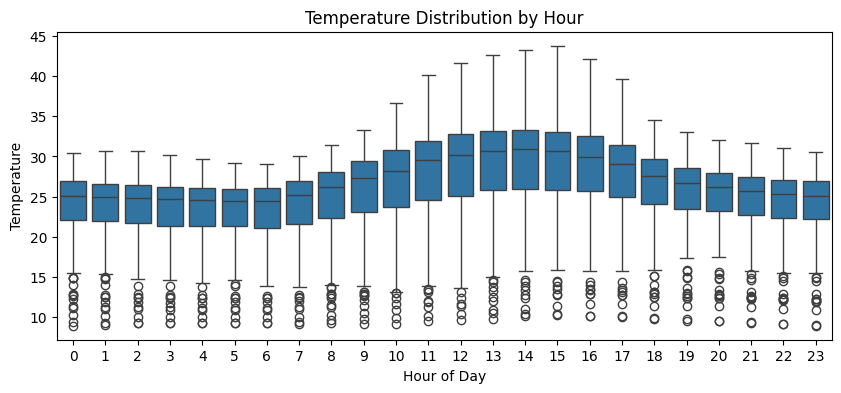

In [27]:
training_data_pandas = training_data_collected.limit(10000).toPandas()

training_data_pandas['hour'] = training_data_pandas['datetime'].dt.hour

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=training_data_pandas['hour'], y=training_data_pandas['temperature'], ax=ax)
ax.set_title('Temperature Distribution by Hour')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Temperature')
plt.show()

In [28]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear,to_timestamp
#t
testing_data_collected = (testing_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)
training_data_collected= (training_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)
testing_data_collected.show(2000)

+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|           datetime|temperature|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|2024-10-30 12:00:00|       27.0|  12|  44|   10|      4|          4|          30|        304|
|2024-10-30 13:00:00|       27.6|  13|  44|   10|      4|          4|          30|        304|
|2024-10-30 14:00:00|       27.9|  14|  44|   10|      4|          4|          30|        304|
|2024-10-30 15:00:00|       27.7|  15|  44|   10|      4|          4|          30|        304|
|2024-10-30 16:00:00|       27.3|  16|  44|   10|      4|          4|          30|        304|
|2024-10-30 17:00:00|       26.2|  17|  44|   10|      4|          4|          30|        304|
|2024-10-30 18:00:00|       25.3|  18|  44|   10|      4|          4|          30|        304|
|2024-10-30 19:00:00|       24.9|  19|  44|   10| 

In [30]:
feature_columns = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")

In [31]:
testing_vectorized = assembler.transform(testing_data_collected).select("features_vector", "temperature")

test_features = np.array(testing_vectorized.select("features_vector").rdd.map(lambda x: x[0]).collect())
test_labels = np.array(testing_vectorized.select("temperature").rdd.map(lambda x: x[0]).collect())

test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))
test_labels = test_labels.reshape((-1, 1))


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/hoan123/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [33]:
# Vector hóa các cột đặc trưng trong training_data_collected
training_vectorized = assembler.transform(training_data_collected).select("features_vector", "temperature")

train_features = np.array(training_vectorized.select("features_vector").rdd.map(lambda x: x[0]).collect())
train_labels = np.array(training_vectorized.select("temperature").rdd.map(lambda x: x[0]).collect())

train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
train_labels = train_labels.reshape((-1, 1))

In [34]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

batch_size = 32
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [35]:
print(train_features.shape)  #
print(train_labels.shape)    ##


(7284, 1, 7)
(7284, 1)


In [37]:
print(train_features_tensor.shape)  # 
print(train_labels_tensor.shape)    ##


torch.Size([7284, 1, 7])
torch.Size([7284, 1])


In [38]:
def create_sequences(features, labels, sequence_length):
    """
    Tạo các chuỗi liên tiếp từ dữ liệu đặc trưng (features) và nhãn (labels).
    
    Args:
        features (ndarray): Dữ liệu đặc trưng.
        labels (ndarray): Dữ liệu nhãn.
        sequence_length (int): Độ dài chuỗi.
    
    Returns:
        tuple: Các chuỗi đặc trưng và nhãn tương ứng.
    """
    sequences = []
    targets = []
    for i in range(len(features) - sequence_length):
        seq = features[i:i + sequence_length]
        target = labels[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Chuẩn bị dữ liệu
sequence_length = 5

# Chuỗi cho tập huấn luyện
train_sequences, train_targets = create_sequences(train_features, train_labels, sequence_length)

# Chuỗi cho tập kiểm tra
test_sequences, test_targets = create_sequences(test_features, test_labels, sequence_length)

# Chuyển đổi thành Tensor
train_features_tensor = torch.tensor(train_sequences, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_targets, dtype=torch.float32)
test_features_tensor = torch.tensor(test_sequences, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_targets, dtype=torch.float32)

# Tạo DataLoader
batch_size = 32
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [39]:
# Loại bỏ chiều thừa ở giữa
train_features_tensor = train_features_tensor.squeeze(2)  # (7264, 20, 7)
test_features_tensor = test_features_tensor.squeeze(2)    # (num_test_samples, 20, 7)

In [40]:
print(train_features_tensor.shape)  # Kỳ vọng: (7264, 20, 7)
print(train_labels_tensor.shape)    # Kỳ vọng: (7264,)


torch.Size([7279, 5, 7])
torch.Size([7279, 1])


In [41]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Lấy đầu ra tại bước thời gian cuối cùng
        output = lstm_out[:, -1, :]
        # Dự đoán giá trị
        output = self.fc(output)
        return output

# Tham số mô hình
input_dim = len(feature_columns)  # Số lượng đặc trưng
hidden_dim = 50  # Số chiều ẩn
output_dim = 1  # Dự đoán một giá trị đầu ra
num_layers = 2  # Số lớp LSTM

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers).to(device)


In [42]:
import torch.optim as optim


In [43]:
# Loss function và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Huấn luyện
epochs = 150
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        if inputs.dim() == 4:
            inputs = inputs.squeeze(2)  # Loại bỏ chiều channels
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/150, Loss: 637.0993
Epoch 2/150, Loss: 467.4502
Epoch 3/150, Loss: 392.0178
Epoch 4/150, Loss: 343.9760
Epoch 5/150, Loss: 303.6421
Epoch 6/150, Loss: 268.3418
Epoch 7/150, Loss: 236.6847
Epoch 8/150, Loss: 208.4047
Epoch 9/150, Loss: 183.0732
Epoch 10/150, Loss: 160.5643
Epoch 11/150, Loss: 140.2969
Epoch 12/150, Loss: 122.2794
Epoch 13/150, Loss: 106.5022
Epoch 14/150, Loss: 92.5253
Epoch 15/150, Loss: 80.2507
Epoch 16/150, Loss: 69.7714
Epoch 17/150, Loss: 60.7753
Epoch 18/150, Loss: 53.2015
Epoch 19/150, Loss: 47.0131
Epoch 20/150, Loss: 41.8488
Epoch 21/150, Loss: 37.7856
Epoch 22/150, Loss: 34.5617
Epoch 23/150, Loss: 32.1058
Epoch 24/150, Loss: 30.3546
Epoch 25/150, Loss: 29.1334
Epoch 26/150, Loss: 28.2420
Epoch 27/150, Loss: 23.7134
Epoch 28/150, Loss: 17.9936
Epoch 29/150, Loss: 16.0131
Epoch 30/150, Loss: 14.6266
Epoch 31/150, Loss: 13.5430
Epoch 32/150, Loss: 12.5635
Epoch 33/150, Loss: 11.8071
Epoch 34/150, Loss: 11.1793
Epoch 35/150, Loss: 10.5897
Epoch 36/150, Lo

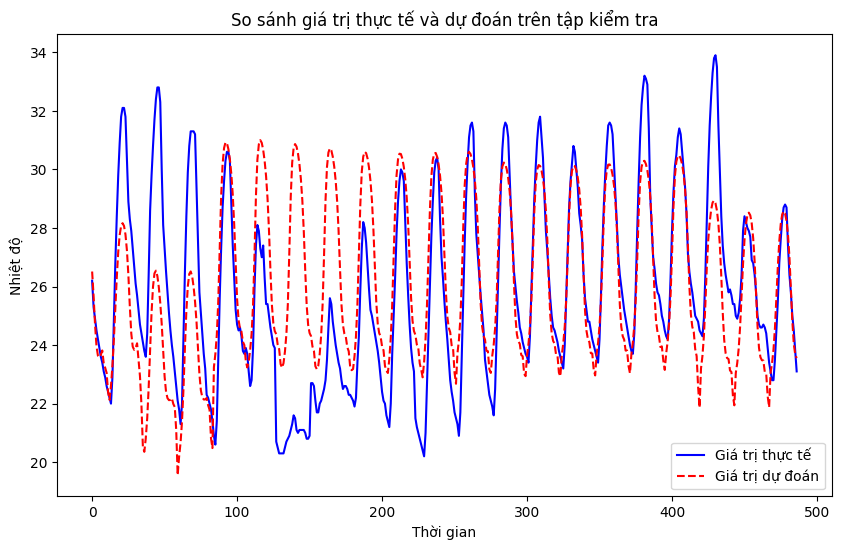

In [44]:
# Đưa mô hình vào chế độ đánh giá
model.eval()

# Dự đoán trên tập kiểm tra
test_predictions = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        if inputs.dim() == 4:
            inputs = inputs.squeeze(2)  # Loại bỏ chiều channels
        outputs = model(inputs)
        test_predictions.append(outputs.numpy())
        test_labels_list.append(labels.numpy())

test_predictions = np.concatenate(test_predictions)
test_labels_list = np.concatenate(test_labels_list)

# Hiển thị biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(test_labels_list, label='Giá trị thực tế', color='blue')
plt.plot(test_predictions, label='Giá trị dự đoán', color='red', linestyle='dashed')
plt.title('So sánh giá trị thực tế và dự đoán trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.show()


In [46]:


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, dropout):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, d_model)  # Embed input features
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1000, d_model))  # Positional encoding
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,  # (batch_size, sequence_length, d_model)
        )
        self.fc_out = nn.Linear(d_model, 1)  # Output layer to predict temperature

    def forward(self, src):
        # Add positional encoding
        seq_len = src.size(1)
        src = self.input_embedding(src) + self.positional_encoding[:, :seq_len, :]
        # Pass through Transformer encoder
        output = self.transformer(src, src)  # Self-attention
        output = self.fc_out(output[:, -1, :])
        return output


In [47]:
# Thông số mô hình
input_dim = 7
d_model = 64
nhead = 8
num_layers = 6
dim_feedforward = 256
dropout = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerModel(input_dim, d_model, nhead, num_layers, dim_feedforward, dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Hàm huấn luyện
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if inputs.dim() == 4:
                inputs = inputs.squeeze(2)  # Loại bỏ chiều channels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")




In [48]:
# Huấn luyện
train(model, train_loader, criterion, optimizer, num_epochs=40)

Epoch [1/40], Loss: 463.0180
Epoch [2/40], Loss: 382.2332
Epoch [3/40], Loss: 313.8126
Epoch [4/40], Loss: 248.6518
Epoch [5/40], Loss: 190.3385
Epoch [6/40], Loss: 141.4171
Epoch [7/40], Loss: 102.3625
Epoch [8/40], Loss: 73.3535
Epoch [9/40], Loss: 53.1882
Epoch [10/40], Loss: 40.4786
Epoch [11/40], Loss: 33.2708
Epoch [12/40], Loss: 29.6352
Epoch [13/40], Loss: 22.4943
Epoch [14/40], Loss: 17.8747
Epoch [15/40], Loss: 15.6126
Epoch [16/40], Loss: 14.6719
Epoch [17/40], Loss: 14.0432
Epoch [18/40], Loss: 13.4204
Epoch [19/40], Loss: 12.9199
Epoch [20/40], Loss: 13.0775
Epoch [21/40], Loss: 12.3738
Epoch [22/40], Loss: 11.8709
Epoch [23/40], Loss: 11.8049
Epoch [24/40], Loss: 11.5841
Epoch [25/40], Loss: 11.0477
Epoch [26/40], Loss: 10.7005
Epoch [27/40], Loss: 10.5368
Epoch [28/40], Loss: 9.9743
Epoch [29/40], Loss: 10.0578
Epoch [30/40], Loss: 9.7427
Epoch [31/40], Loss: 9.3925
Epoch [32/40], Loss: 9.4665
Epoch [33/40], Loss: 9.2126
Epoch [34/40], Loss: 8.9680
Epoch [35/40], Loss: 8

In [49]:
def evaluate(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            if inputs.dim() == 4:
                inputs = inputs.squeeze(2)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().cpu().numpy())
            actuals.extend(labels.cpu().numpy())
    return predictions, actuals

predictions, actuals = evaluate(model, test_loader)


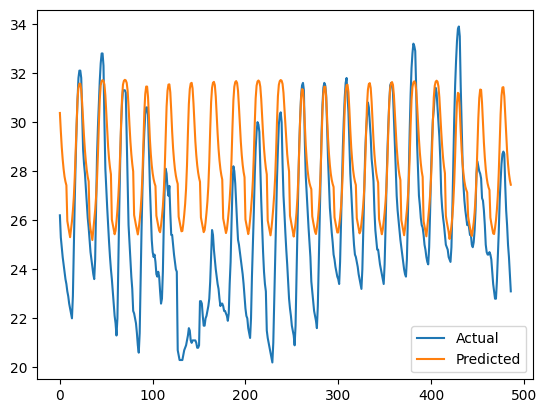

In [50]:
import matplotlib.pyplot as plt

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.show()


In [51]:
X_train_pd = X_train.withColumn("datetime", col("datetime").cast("string")).toPandas()
y_train_pd = y_train.toPandas()
X_test_pd = X_test.withColumn("datetime", col("datetime").cast("string")).toPandas()
y_test_pd = y_test.toPandas()

1370/1370 [==============================] - 79s 58ms/step
RMSE: 3.4138443666509346


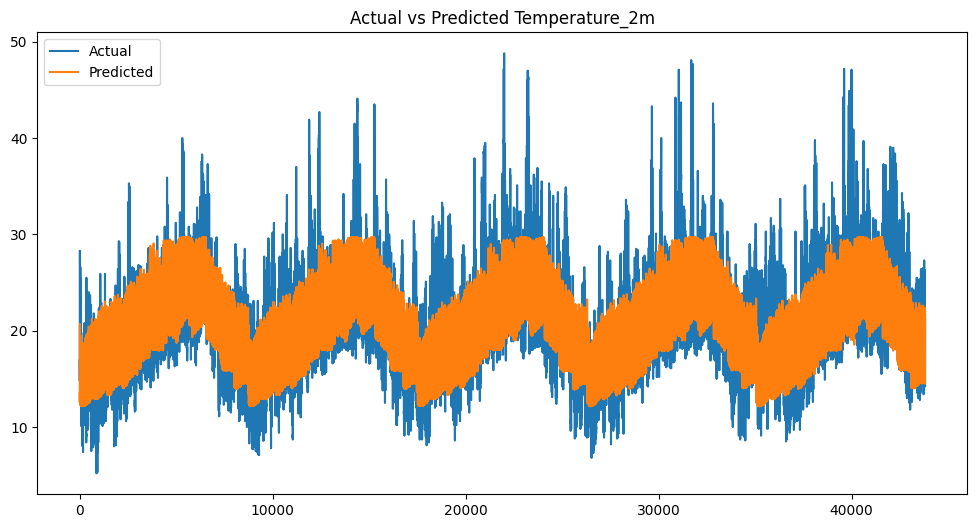

In [ ]:
y_pred = model.predict(X_test_seq)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
print("RMSE:", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Temperature_2m')
plt.legend()
plt.show()

In [ ]:
import os

model_save_path = 'models/model_lstm'
os.makedirs('models', exist_ok=True)
save_model(model, model_save_path)



INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


In [ ]:

loaded_model = load_model(model_save_path)


1370/1370 [==============================] - 76s 54ms/step
RMSE (loaded model): 3.4138443666509346


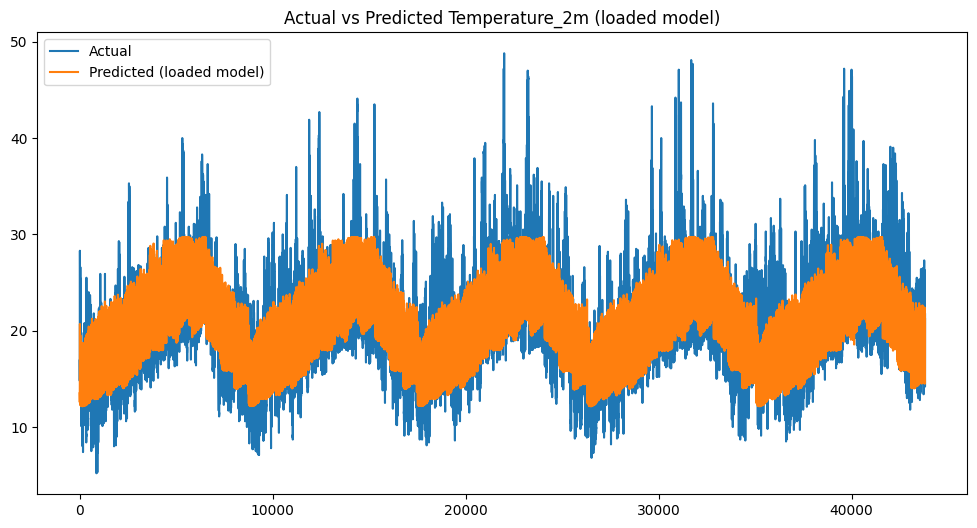

In [ ]:

y_pred_loaded = loaded_model.predict(X_test_seq)

rmse_loaded = np.sqrt(mean_squared_error(y_test_seq, y_pred_loaded))
print("RMSE (loaded model):", rmse_loaded)

plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_loaded, label='Predicted (loaded model)')
plt.title('Actual vs Predicted Temperature_2m (loaded model)')
plt.legend()
plt.show()